## <center>                            Microsoft Volatility Analysis Project 

####  <center>                  presented by Brian Zamkotowicz for Springboard Capstone Project

### <center>  Part 3 - Inferential Statistics Notebook

This third notebook follows up on the work done in the earlier Data Wrangling and Data Visualization notebooks.  It will explore trends in historical volatility, and attempt to establish a quantifiable relationship between historical volatility in Microsoft stock and a number of other features.  In particular it will focus on ECDF and heatmaps, as well as incorporating Python's statsmodel and sklearn packages for statistical analysis.



In [3]:
#import packages for project

import plotly
from pyramid.arima import auto_arima
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import quandl
import plotly.plotly as ply
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from datetime import datetime
import seaborn as sns

C:\Conda\lib\site-packages\pyramid\__init__.py:68: UserWarning:


    The 'pyramid' package will be migrating to a new namespace beginning in 
    version 1.0.0: 'pmdarima'. This is due to a package name collision with the
    Pyramid web framework. For more information, see Issue #34:
    
        https://github.com/tgsmith61591/pyramid/issues/34
        
    The package will subsequently be installable via the name 'pmdarima'; the
    only functional change to the user will be the import name. All imports
    from 'pyramid' will change to 'pmdarima'.
    



In [4]:
#unpack pickled data from previous Data Wrangling Notebook

MSFT_data = pd.read_pickle('C://Users/Home Office/MSFTdata.pickle')

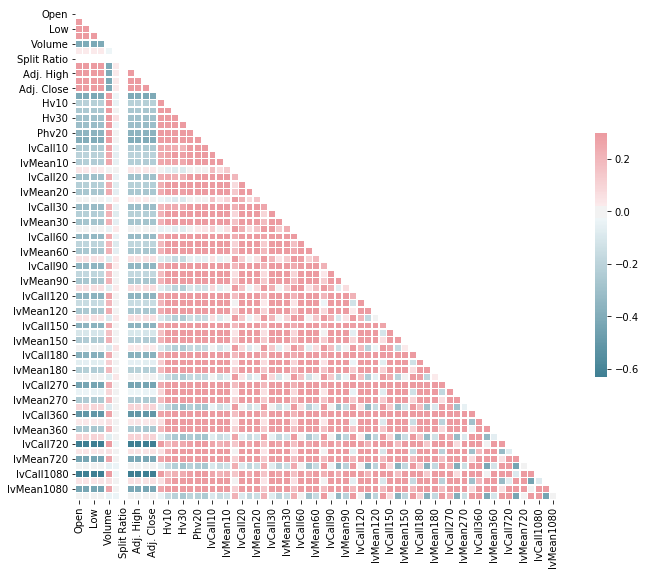

In [5]:
# Compute the correlation matrix
corr = MSFT_data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

This heatmap is a bit overwhelming, and there is quite a bit of overlap between the information.  This will be more useful if it can be paired down to include less categories.

In [6]:
MSFT_data.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2017-12-29 to 2013-01-02
Data columns (total 66 columns):
Open              1258 non-null float64
High              1258 non-null float64
Low               1258 non-null float64
Close             1258 non-null float64
Volume            1258 non-null float64
Ex-Dividend       1258 non-null float64
Split Ratio       1258 non-null float64
Adj. Open         1258 non-null float64
Adj. High         1258 non-null float64
Adj. Low          1258 non-null float64
Adj. Close        1258 non-null float64
Adj. Volume       1258 non-null float64
Hv10              1258 non-null float64
Hv20              1258 non-null float64
Hv30              1258 non-null float64
Phv10             1258 non-null float64
Phv20             1258 non-null float64
Phv30             1258 non-null float64
IvCall10          1258 non-null float64
IvPut10           1258 non-null float64
IvMean10          1258 non-null float64
IvMeanSkew10      1258 non-null flo

Since Call and Put Implied Volatilities should be very similar to the mean I can drop them to make the data frame more manageable.

In [7]:
MSFT_data = MSFT_data.drop(MSFT_data.filter(regex='Call').columns, axis=1)
MSFT_data = MSFT_data.drop(MSFT_data.filter(regex='Put').columns, axis=1)

In [8]:
MSFT_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2017-12-29 to 2013-01-02
Data columns (total 42 columns):
Open              1258 non-null float64
High              1258 non-null float64
Low               1258 non-null float64
Close             1258 non-null float64
Volume            1258 non-null float64
Ex-Dividend       1258 non-null float64
Split Ratio       1258 non-null float64
Adj. Open         1258 non-null float64
Adj. High         1258 non-null float64
Adj. Low          1258 non-null float64
Adj. Close        1258 non-null float64
Adj. Volume       1258 non-null float64
Hv10              1258 non-null float64
Hv20              1258 non-null float64
Hv30              1258 non-null float64
Phv10             1258 non-null float64
Phv20             1258 non-null float64
Phv30             1258 non-null float64
IvMean10          1258 non-null float64
IvMeanSkew10      1258 non-null float64
IvMean20          1258 non-null float64
IvMeanSkew20      1258 non-null flo

Also since we are looking at adjusted (for splits) data I can drop the unadjusted high, low, close etc.

In [9]:
#drop unnescessary columns to improve appearance of heatmap

MSFT1= MSFT_data.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume', 'Ex-Dividend', 'Split Ratio'])

In [10]:
#eliminate longer dated skew columns
MSFT1 = MSFT1.drop(columns= ['IvMeanSkew60','IvMeanSkew90', 'IvMeanSkew120', 'IvMeanSkew150', 'IvMeanSkew180', 'IvMeanSkew270', 'IvMeanSkew360', 'IvMeanSkew720', 'IvMeanSkew1080'])

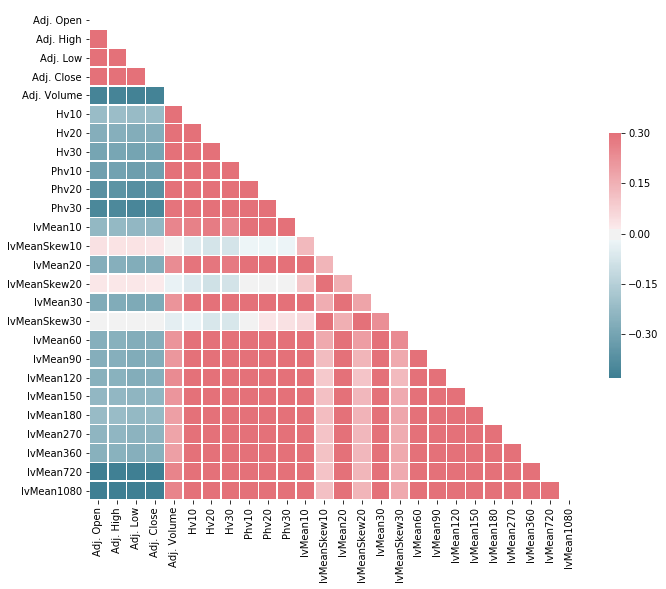

In [11]:
# Compute the correlation matrix
corr1 = MSFT1.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr1, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr1, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

The heatmap seems to show that historical volatilities don't show any correlation (or even show slightly negative correlation) to stock prices (open, high, low, close).  This makes sense as stocks that trend higher tend to exhibit lower volatility.  The historical volatility does appear to have a positive relationship to applied volatilitity.  Higher volume also seems to correlate to greater historical volatility.

In the previous notebook I was able to isolate both trend in seasonality in the price of Microsoft stock.  I would like to explore whether trends in seasonality exist withing the historical volatility of the sock as well.

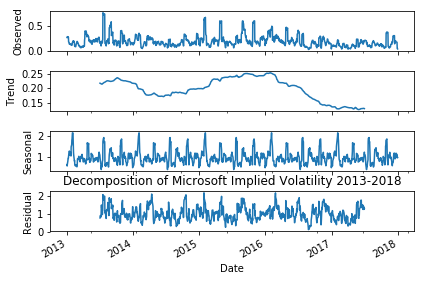

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose
vol = MSFT1['Hv10']

result = seasonal_decompose(vol, model='multiplicative', freq = 252)
result.plot()
plt.title('Decomposition of Microsoft Implied Volatility 2013-2018')
plt.show()

The seasonal decompose of historical volatility does provide some interesting results.  There does seem to be a bit of a seasonal pattern and it seems to be inverse to the seasonal pattern of price.  Volality seems to be low toards the end of the calendar year and pick up up early in the year.  The trend is nowhere near as obvious as the trend in stock price. There seems to be a period of increased volatilitility in 2015-2016 before settling into a ppattern of low volatility.

[]

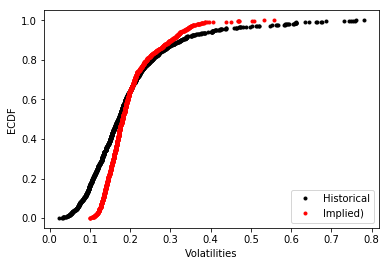

In [18]:
# plot ECDF's of historical and implied 10 day volatilities

x = np.sort(MSFT1['Hv10'])
y = np.arange(1, len(x)+1)/len(x)
_ = plt.plot(x, y, marker = '.', linestyle = 'none', color = "black")

x1 = np.sort(MSFT1['IvMean10'])
y1 = np.arange(1, len(x)+1)/len(x)
_ = plt.plot(x1, y1, marker = '.', linestyle = 'none', color = "red")

plt.legend(('Historical', 'Implied)'), loc = 'lower right')
plt.xlabel('Volatilities')
plt.ylabel('ECDF')
plt.plot()

[]

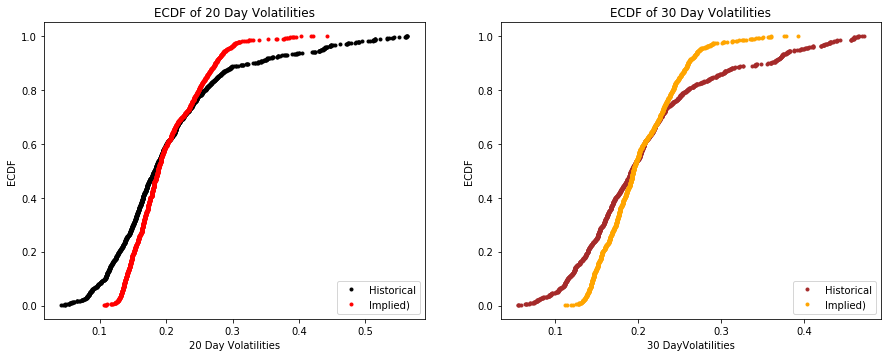

In [19]:
fig = plt.figure()
fig.set_figheight(12)
fig.set_figwidth(15)

# plot ECDF's of historical and implied 20 day volatilities

ax1 = fig.add_subplot (2,2,1)
xHv20 = np.sort(MSFT1['Hv20'])
yHv20 = np.arange(1, len(x)+1)/len(x)
_ = plt.plot(xHv20, yHv20, marker = '.', linestyle = 'none', color = "black")

xIv20 = np.sort(MSFT1['IvMean20'])
yIv20= np.arange(1, len(x)+1)/len(x)
_ = plt.plot(xIv20, yIv20, marker = '.', linestyle = 'none', color = "red")
plt.legend(('Historical', 'Implied)'), loc = 'lower right')
plt.xlabel('20 Day Volatilities')
plt.ylabel('ECDF')
plt.title('ECDF of 20 Day Volatilities')

ax2 = fig.add_subplot (2,2,2)
xHv30 = np.sort(MSFT1['Hv30'])
yHv30 = np.arange(1, len(x)+1)/len(x)
_ = plt.plot(xHv30, yHv30, marker = '.', linestyle = 'none', color = "brown")

xIv30 = np.sort(MSFT1['IvMean30'])
yIv30= np.arange(1, len(x)+1)/len(x)
_ = plt.plot(xIv30, yIv30, marker = '.', linestyle = 'none', color = "orange")
plt.legend(('Historical', 'Implied)'), loc = 'lower right')
plt.xlabel('30 DayVolatilities')
plt.ylabel('ECDF')
plt.title('ECDF of 30 Day Volatilities')
plt.plot()

The above diagrams show the ecdf for the 20 and 30 day implied and historical volatilities.  What is noticeable is that in the 20 and 30 day volatilities, there seem to be a greater proportion of days where implied volatility is below historical.  The market seems to make an assumption that given enough time, outlier historical volatilities will regress back to "normal", and the longer the time period given the more likely that regression to mean is.

Statsmodel shows an adjusted r-squared score of 68 % meaning that a reasonable amount of variance in historical volatility of Microsoft stock can be explained by a model using implied volatility of at-the-money options as a predictor. The t-score (P>|t|) of zero (likely just a very small number) indicates that there is a statistically significant relationship between the two variables.

In [51]:
from sklearn.linear_model import LinearRegression

#drop 20 and 30 day historical vol to eliminate some colinearity
MSFT2 = MSFT1.drop(['Hv20', 'Hv30', 'Phv20', 'Phv30'], axis = 1)

HistVol = MSFT2.drop('Hv10', axis = 1)

# This creates a LinearRegression object
lm = LinearRegression()

lm.fit(HistVol, MSFT1.Hv10)

# The coefficients
pd.DataFrame({'features': HistVol.columns, 'estimatedCoefficients': lm.coef_})[['features', 'estimatedCoefficients']]

,features,estimatedCoefficients
0,Adj. Open,-9.922066e-03
1,Adj. High,-1.775061e-02
2,Adj. Low,3.917565e-02
3,Adj. Close,-1.053483e-02
4,Adj. Volume,1.783284e-09
5,Phv10,1.355700e+00
6,Phv20,1.034317e-01
7,Phv30,1.688565e-01
8,IvMean10,-1.963190e-01
9,IvMeanSkew10,3.936278e-02


The table above shows the correlation coefficients of the other features and how the relate to the ten day historical volatility of the stock.

Text(0.5,1,'Relationship Between Predicted and Actual Volatility')

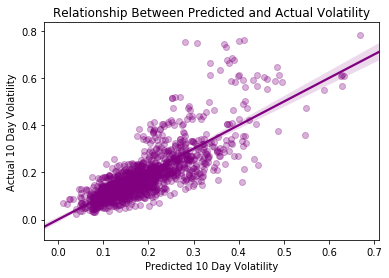

In [59]:
sns.regplot((lm.predict(HistVol)), MSFT1.Hv10, color = 'purple', scatter_kws={'alpha':0.3})
plt.xlabel("Predicted 10 Day Volatility")
plt.ylabel("Actual 10 Day Volatility")
plt.title("Relationship Between Predicted and Actual Volatility")

In the above regression plot it can be observed that when actual volatility goes above 40% the model has difficulty predicting the actual volatility. Conversely there are are a reasonable amount of predictions in the 30-40% range that are higher than the actual volatility.

This notebook used statistical analysis techniques to explore the existing data about Microsoft stock volatility.  Relationships between historical volatility and other features were explored in an attempt to find patterns within the data.

Going forward machine learning techniques will be applied to the time series data to build models that will predict the historical volatility of the stock into the future.